MDD(%) k=0.3: -25.141201133043655
hpr(%) k=0.3: 0.8554480433632927 

MDD(%) k=0.5: -29.190860570422338
hpr(%) k=0.5: 0.8397192220423904 

MDD(%) k=0.7: -20.93036981811396
hpr(%) k=0.7: 0.9531579295750356 

MDD(%) BTC: -63.38599671933005
hpr(%) BTC: 0.3707167832167832 



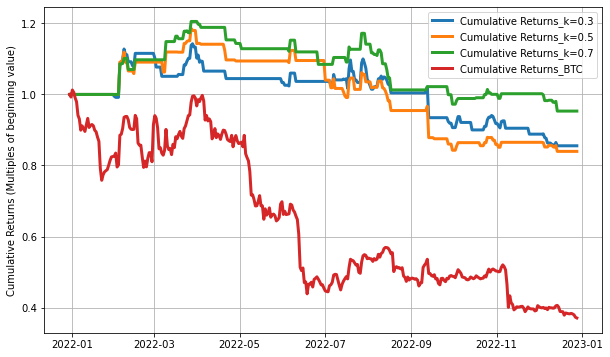

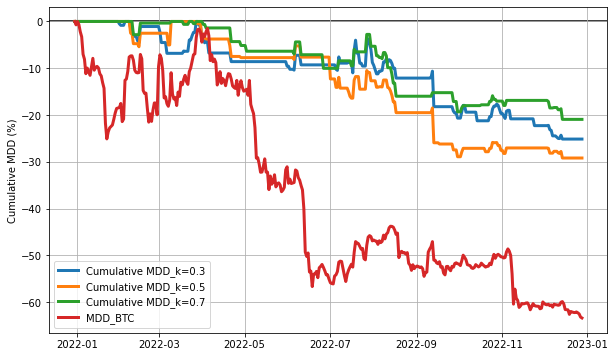

In [233]:
import pyupbit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def backtest(ticker='KRW-BTC', bt_period=365, ma_period=15, k=0.5):
    price_df = pyupbit.get_ohlcv(ticker, count = bt_period + ma_period)
    price_df.index.name = 'Datetime'
    price_df['range'] = price_df['high'] - price_df['low']
    price_df['target'] = price_df['open'] + (price_df['range'].shift(1)) * k

    # 15-MA up to yesterday's closing price (MA_t-1) is only known at today's market open 
    # For real trading, 15-MA up to today's current price may be used to reflect changing condition
    # for backtesting purpose, reflect only 14-MA up to yesterday as today's current price has less effect on actual 15-MA condition
    ma_shift = 1 
    ma_period=15

    # Past 15-MA condition
    ma15 = price_df['close'].rolling(ma_period).mean().shift(ma_shift)
    # Past 14-MA condition
    ma14 = price_df['close'][1:].shift(ma_shift).rolling(ma_period - ma_shift).mean()

    price_df['shifted_ma'] = ma15
    price_df = price_df[ma_period:]

    ## Meet initial condition that any target is above 15-MA, if below 15-MA, no buys
    price_df['above_ma'] = price_df['target'] >= price_df['shifted_ma']

    ## Conditioned on Target Price -> (target <= current price) & (shifted_ma <= target))
    ## current price movement is implied by daily high exceeding above target
    price_df['Daily Returns_Autotrade'] =  np.where(((price_df['high'] >= price_df['target']) & price_df['above_ma']), price_df['close'] / price_df['target'], 1)

    ## Cumulative Returns over the whole period
    price_df['Cumulative Returns_Autotrade'] = price_df['Daily Returns_Autotrade'].cumprod()

    ## Cumulative Maximum Draw Down = (today hpr - cummulative max hpr)/ cummulative max hpr
    price_df['MDD_Autotrade'] = (price_df['Cumulative Returns_Autotrade'] / price_df['Cumulative Returns_Autotrade'].cummax() - 1) * 100

    ## Cumulative Returns of BTC
    price_df['Cumulative Returns_BTC'] = price_df['close']/price_df['close'].iloc[0]

    ## Cumulative MDD of BTC
    price_df['MDD_BTC'] = (price_df['Cumulative Returns_BTC'] / price_df['Cumulative Returns_BTC'].cummax() - 1) * 100
    
    return price_df

def main():
    period = 365
    
    # Vary k
    k_low = backtest(bt_period=period, ma_period=15, k=0.3)
    k_mid = backtest(bt_period=period, ma_period=15, k=0.5)
    k_high = backtest(bt_period=period, ma_period=15, k=0.7)
    
    ### MDD = max cummulative dd
    k_l=0.3
    print(f"MDD(%) k={k_l}: {k_low['MDD_Autotrade'].min()}") 
    print(f"hpr(%) k={k_l}: {k_low['Cumulative Returns_Autotrade'][-1]}", "\n")
    k_m=0.5
    print(f"MDD(%) k={k_m}: {k_mid['MDD_Autotrade'].min()}") 
    print(f"hpr(%) k={k_m}: {k_mid['Cumulative Returns_Autotrade'][-1]}", "\n")
    k_h=0.7
    print(f"MDD(%) k={k_h}: {k_high['MDD_Autotrade'].min()}") 
    print(f"hpr(%) k={k_h}: {k_high['Cumulative Returns_Autotrade'][-1]}", "\n")
    
    print(f"MDD(%) BTC: {k_high['MDD_BTC'].min()}") 
    print(f"hpr(%) BTC: {k_high['Cumulative Returns_BTC'][-1]}", "\n")
    
    # Graph Cumulative Returns
    plt.figure(figsize=(10,6))
    plt.plot(k_low['Cumulative Returns_Autotrade'], linewidth=3, label=f'Cumulative Returns_k={k_l}')
    plt.plot(k_mid['Cumulative Returns_Autotrade'], linewidth=3, label=f'Cumulative Returns_k={k_m}')
    plt.plot(k_high['Cumulative Returns_Autotrade'], linewidth=3, label=f'Cumulative Returns_k={k_h}')

    plt.plot(k_high['Cumulative Returns_BTC'], linewidth=3, label='Cumulative Returns_BTC')


    plt.ylabel('Cumulative Returns (Multiples of beginning value)')
    plt.grid()
    plt.legend();
    
    # Graph Cumulative MDD
    plt.figure(figsize=(10,6))
    plt.plot(k_low['MDD_Autotrade'], linewidth=3, label=f'Cumulative MDD_k={k_l}')
    plt.plot(k_mid['MDD_Autotrade'], linewidth=3, label=f'Cumulative MDD_k={k_m}')
    plt.plot(k_high['MDD_Autotrade'], linewidth=3, label=f'Cumulative MDD_k={k_h}')

    plt.plot(k_mid['MDD_BTC'], linewidth=3, label='MDD_BTC')
    plt.axhline(0, color='black', zorder=0)
    
    plt.ylabel('Cumulative MDD (%)')
    plt.grid()
    plt.legend();
    
    plt.show()

if __name__ == '__main__':
    main()